1/1 [==============================] - 1s 712ms/step


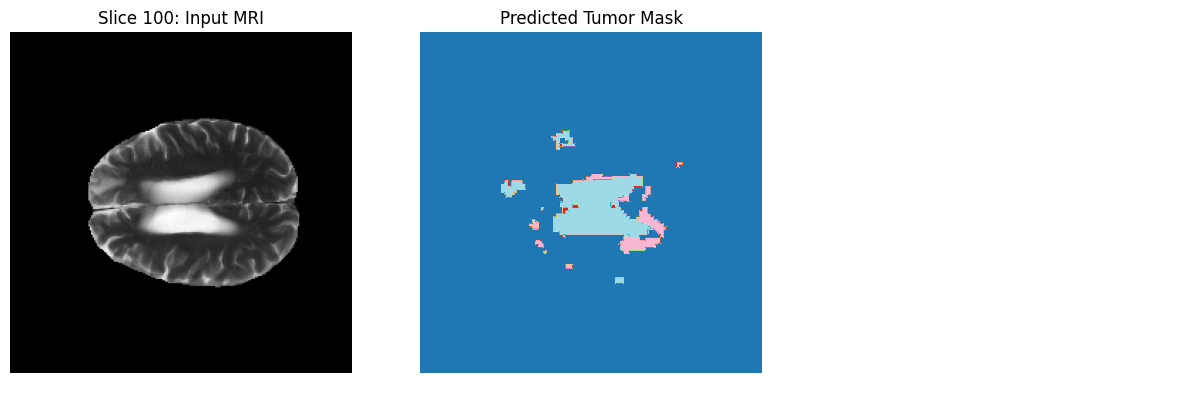

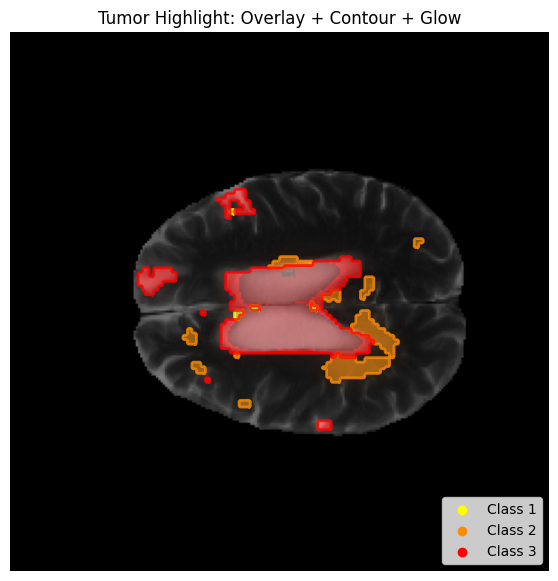

1/1 [==============================] - 0s 140ms/step


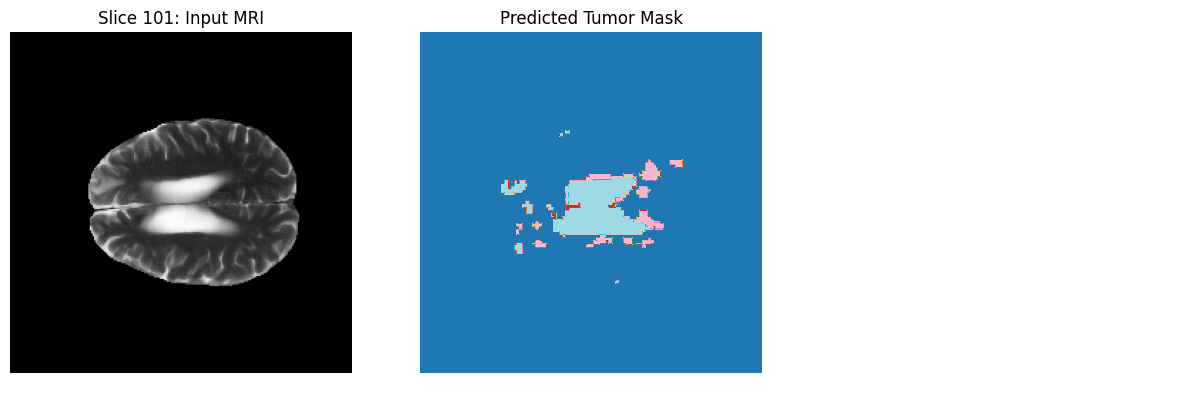

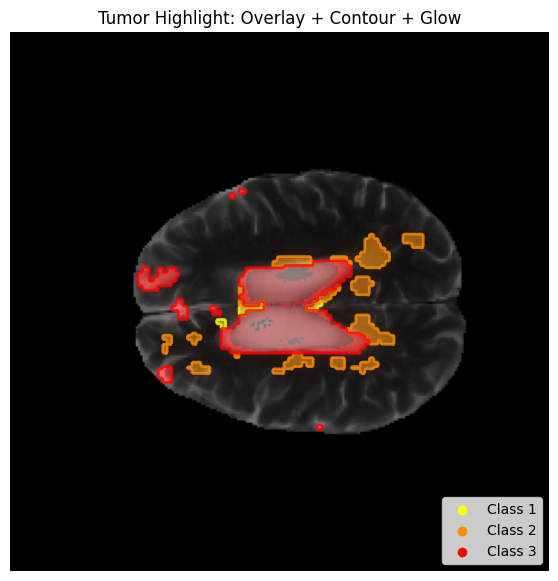

1/1 [==============================] - 0s 147ms/step


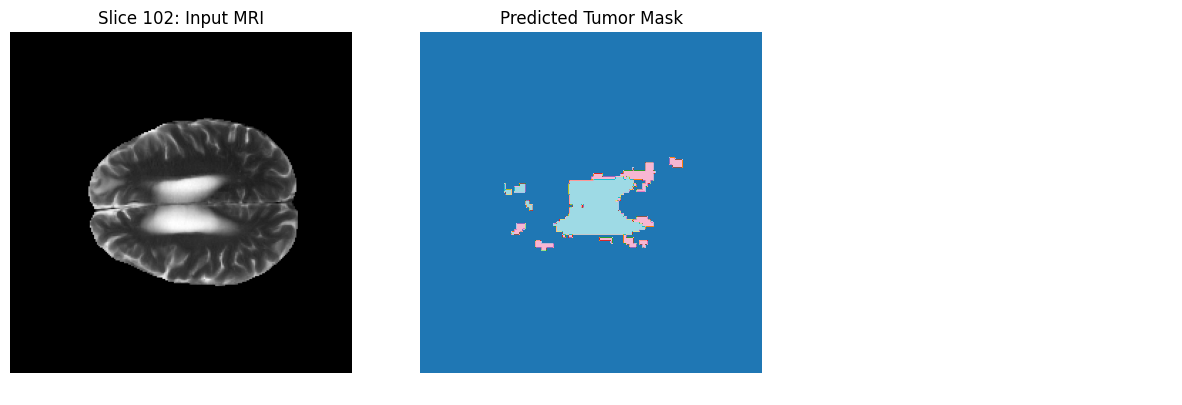

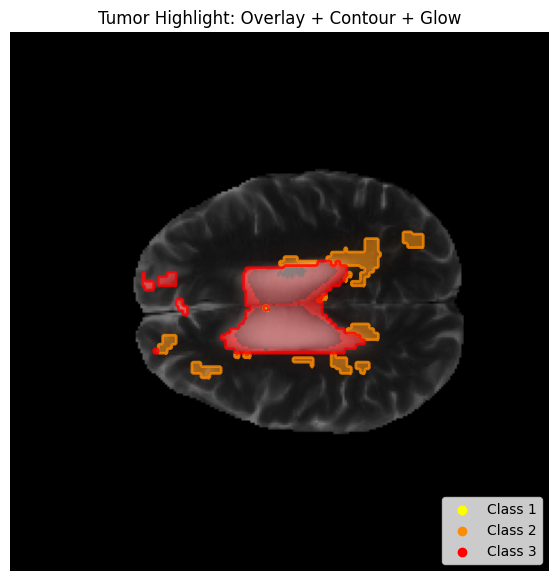

Done!


In [2]:
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from skimage import measure
import tensorflow as tf

# ==== Load model ====
model = tf.keras.models.load_model( "../models/finalunet.h5", compile=False)

def normalize(img):
    img = np.nan_to_num(img)
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

def show_creative_tumor_overlay(orig_slice, pred_mask, class_colors=None):
    """
    orig_slice: 2D MRI slice, normalized (0-1)
    pred_mask: 2D predicted mask (integer labels, 0=background, 1,2,3 for classes)
    class_colors: dict, {label: (R,G,B)} for overlay color, e.g. {1:(255,255,0)}
    """
    H, W = orig_slice.shape
    orig_disp = (orig_slice * 255).astype(np.uint8)
    orig_rgb = cv2.cvtColor(orig_disp, cv2.COLOR_GRAY2RGB)
    
    # 1. Semi-transparent color overlay
    overlay = orig_rgb.copy()
    alpha = 0.5
    if class_colors is None:
        # Default: 1=yellow, 2=orange, 3=red
        class_colors = {1:(255,255,0), 2:(255,140,0), 3:(255,0,0)}
    
    mask_vis = np.zeros_like(orig_rgb)
    for label, color in class_colors.items():
        mask = (pred_mask == label)
        mask_vis[mask] = color
    blended = cv2.addWeighted(orig_rgb, 1-alpha, mask_vis, alpha, 0)
    
    # 2. Tumor contour lines (highlighted edges)
    plt.figure(figsize=(7,7))
    plt.imshow(blended)
    for label, color in class_colors.items():
        if np.any(pred_mask == label):
            contours = measure.find_contours(pred_mask == label, 0.5)
            for c in contours:
                c = np.flip(c, axis=1)  # (y, x) → (x, y)
                plt.plot(c[:, 0], c[:, 1], linewidth=2, color=np.array(color)/255, alpha=0.8)

    # 3. Glow effect (optional: add a blurred mask below the color)
    for label, color in class_colors.items():
        if np.any(pred_mask == label):
            mask = (pred_mask == label).astype(np.float32)
            mask_blur = cv2.GaussianBlur(mask, (0,0), sigmaX=6, sigmaY=6)
            glow = np.zeros_like(orig_rgb, dtype=np.float32)
            for ch in range(3):
                glow[..., ch] = color[ch] * mask_blur * 0.3  # Glow strength
            blended = np.clip(blended + glow.astype(np.uint8), 0, 255).astype(np.uint8)
            plt.imshow(blended, alpha=0.3)  # Overlay the glow

    # 4. Legend
    for label, color in class_colors.items():
        plt.scatter([], [], color=np.array(color)/255, label=f'Class {label}')
    plt.legend(loc='lower right')
    plt.title("Tumor Highlight: Overlay + Contour + Glow")
    plt.axis('off')
    plt.show()

def predict_and_show_creative(nifti_path, model, image_size=(128,128), slice_indices=None, num_classes=4):
    nii = nib.load(nifti_path)
    volume = nii.get_fdata()
    H, W, D = volume.shape

    # If not specified, just pick the middle 8 slices
    if slice_indices is None:
        start = D // 2 - 4
        slice_indices = list(range(max(0, start), min(D, start+8)))

    for idx, i in enumerate(slice_indices):
        # --- Prepare input ---
        img_slice = normalize(volume[:, :, i])
        img_resized = cv2.resize(img_slice, image_size)
        inp = img_resized[np.newaxis, ..., np.newaxis]  # (1,128,128,1)

        # --- Predict ---
        pred = model.predict(inp)[0]    # (128,128,4)
        pred_mask = np.argmax(pred, axis=-1).astype(np.uint8)  # (128,128)

        # Resize mask back to original size for display
                # Resize mask back to original size for display
        pred_mask_full = cv2.resize(pred_mask, (H, W), interpolation=cv2.INTER_NEAREST)
        orig_disp_full = normalize(volume[:, :, i])  # shape (H, W), normalized

        # --- Show: Input MRI | Predicted Mask | Creative Overlay ---
        plt.figure(figsize=(15,5))
        
        # 1. Input
        plt.subplot(1,3,1)
        plt.imshow(orig_disp_full, cmap='gray')
        plt.title(f'Slice {i}: Input MRI')
        plt.axis('off')

        # 2. Mask
        plt.subplot(1,3,2)
        plt.imshow(pred_mask_full, cmap='tab20')
        plt.title('Predicted Tumor Mask')
        plt.axis('off')

        # 3. Overlay
        plt.subplot(1,3,3)
        plt.axis('off')
        show_creative_tumor_overlay(orig_disp_full, pred_mask_full)
        plt.close()
  # Prevent duplicate display

    print("Done!")

# ==== USAGE ====
predict_and_show_creative(
    nifti_path= "../data/brats-men-train/BraTS-MEN-00008-000/BraTS-MEN-00008-000-t2w.nii",    # <-- PUT YOUR FILE PATH HERE
    model=model,
    image_size=(128,128),
    slice_indices=[100,101,102]             # <-- Slices you want to view, or leave as None for middle 8 slices
)


| Color  | Label Value | Medical Term                                        | Description                                                                                   |
| ------ | ----------- | --------------------------------------------------- | --------------------------------------------------------------------------------------------- |
| Yellow | 1           | **Necrotic and Non-Enhancing Tumor Core (NCR/NET)** | The inner part of the tumor that is either dead tissue or does not enhance with contrast.     |
| Orange | 2           | **Peritumoral Edema (ED)**                          | Swollen tissue around the tumor, often containing fluid.                                      |
| Red    | 3           | **Enhancing Tumor (ET)**                            | Tumor part that actively takes up contrast, usually the most aggressive and dangerous region. |
